# Monet Style Transfer with GANs Kaggle Mini-Project

## Brief description of the problem and data

In this project, the goal is to build a GAN that generates 7,000 to 10,000 Monet-style images.

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing that we have created a true Monet? That’s the challenge we shall take on!

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

## Exploratory Data Analysis (EDA)

In this project we are going to use CycleGAN for style tranfer. First we need to import all python packages / functions that are required (install the ones that are not already installed with `pip`) for building the GAN model. We shall use tensorflow / keras to train the generative model.

In [ ]:
import numpy as np
import re, os, shutil
from glob import glob
import tqdm
import matplotlib.pylab as plt

# for building the model
import tensorflow as tf
import tensorflow.keras.backend as K
#! pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, losses

Let's read the `tfrecords` and create a `tensorflow` `ZipDataset` by combining the photo and monte style images. We can see that the number of monet style images (300) is much smaller than number of photo images (7038), so the images are not paired.

In [3]:
def load_dataset(filenames, labeled=True, ordered=False, autotune=tf.data.experimental.AUTOTUNE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autotune)
    return dataset

def decode_image(image, img_size=[256,256,3]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1        
    image = tf.reshape(image, img_size)             
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image":      tf.io.FixedLenFeature([], tf.string),
        "target":     tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)  
    image = decode_image(example['image'])    
    return image

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

data_path = 'gan-getting-started'
monet_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'monet_tfrec', '*.tfrec')))
photo_filenames = tf.io.gfile.glob(str(os.path.join(data_path, 'photo_tfrec', '*.tfrec')))

monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)

n_monet_samples = count_data_items(monet_filenames)
n_photo_samples = count_data_items(photo_filenames)
dataset = tf.data.Dataset.zip((monet_ds, photo_ds))

n_monet_samples, n_photo_samples
# (300, 7038)

Let's plot a few sample images from monet style and photo images.

In [4]:
def plot_images(images, title):
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    j = 1
    for i in np.random.choice(len(images), 100, replace=False):
        plt.subplot(10,10,j), plt.imshow(images[i] / images[i].max()), plt.axis('off')
        j += 1
    plt.suptitle(title, size=25)
    plt.show()

monet_numpy = list(monet_ds.as_numpy_iterator())
plot_images(monet_numpy, 'Monet images')

### Monet Style input images

![](images/monet_montage.png)

In [ ]:
plot_images(list(photo_ds.as_numpy_iterator()), 'Photo images')

### Photo input images

![](images/photo_montage.png)

## Preprocessing

As can be seen, the images are transformed to have values in between [-1,1], implemented with the function `decode_image()` above.

## Model Architecture

Paired data is harder to find in most domains, and not even possible in some, the unsupervised training capabilities of **CycleGAN** are quite useful, it does not require paired training data (which we don't have in this case, we have 300 monet images and ~7k photo images). Hence, the problem can be forumulated as unpaired image-to-image translation and CycleGAN is an ideal model to be used here. We shall train the CycleGAN model on the image dataset provided (to translate from photo to monet style images) and then use the Genrator to generate monet images later. The next figure shows the architecture and the next code snippet provides the implementation:

![](images/arch.png)

In [5]:
class CycleGAN(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def generate(self, image):
        return self.m_gen(tf.expand_dims(image, axis=0), training=False)

    def load(
        self, 
        filepath
    ):
        self.m_gen.load_weights(filepath.replace('model_name', 'm_gen'), by_name=True)
        self.p_gen.load_weights(filepath.replace('model_name', 'p_gen'), by_name=True)
        self.m_disc.load_weights(filepath.replace('model_name', 'm_disc'), by_name=True)
        self.p_disc.load_weights(filepath.replace('model_name', 'p_disc'), by_name=True)

    def save(
        self, 
        filepath
    ):
        self.m_gen.save(filepath.replace('model_name', 'm_gen'))
        self.p_gen.save(filepath.replace('model_name', 'p_gen'))
        self.m_disc.save(filepath.replace('model_name', 'm_disc'))
        self.p_disc.save(filepath.replace('model_name', 'p_disc'))

        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            real_photo = tf.expand_dims(real_photo, axis=0)
            real_monet = tf.expand_dims(real_monet, axis=0)

            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        total_loss = total_monet_gen_loss + total_photo_gen_loss + monet_disc_loss + photo_disc_loss

        return {
            "total_loss": total_loss,
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of two generator models and two discriminator models. The CycleGAN uses an additional extension to the architecture called cycle consistency. This is the idea that an image output by the first generator could be used as input to the second generator and the output of the second generator should match the original image. 

The Discriminator is a deep convolutional neural network that performs image classification. It takes a source image as input and predicts the likelihood of whether the target image is a real or fake image. Two discriminator models are used, one for Domain-A (photos) and one for Domain-B (monets). 

![](images/disc.png)

The generator is an encoder-decoder model architecture. The discriminator models are trained directly on real and generated images, whereas the generator models are not. The model takes a source image (e.g. a photo) and generates a target image (e.g. a monet image). It does this by first downsampling or encoding the input image down to a bottleneck layer, then interpreting the encoding with a number of ResNet layers that use skip connections, followed by a series of layers that upsample or decode the representation to the size of the output image. 

![](images/gen.png)

In [ ]:
def Generator(img_shape=[256, 256, 3]):
    inputs = layers.Input(shape=img_shape)
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)


def Discriminator(img_shape=[256, 256, 3]):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=img_shape, name='input_image')
    x = inp

    x = downsample(64, 4, False)(x) 
    x = downsample(128, 4)(x) 
    x = downsample(256, 4)(x) 

    x = layers.ZeroPadding2D()(x) 
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x) 
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x) 
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) 

    return tf.keras.Model(inputs=inp, outputs=x)

In [ ]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def discriminator_loss(real, generated):
    real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def generator_loss(generated):
    return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
        
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, LAMBDA):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

In [6]:
img_shape = [256, 256, 3]

model = CycleGAN(
    monet_generator=Generator(img_shape),
    photo_generator=Generator(img_shape),
    monet_discriminator=Discriminator(img_shape),
    photo_discriminator=Discriminator(img_shape),
    lambda_cycle=10
)

model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_gen_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    m_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    p_disc_optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)

## Results and Analysis

Let's train the GAN model (both the generators and discriminators simultaneously) for 50 epochs.

In [7]:
# Train the model
batch_size = 32
#tf.config.run_functions_eagerly(True)
#tf.get_logger().setLevel('INFO')
epochs = 50
history = model.fit(dataset, epochs=epochs, batch_size=batch_size)

Epoch 1/50


2023-03-27 19:18:41.116027: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 178s 442ms/step - total_loss: 13.5143 - monet_gen_loss: 6.0788 - photo_gen_loss: 6.2427 - monet_disc_loss: 0.6130 - photo_disc_loss: 0.5799
Epoch 2/50
300/300 [==============================] - 132s 440ms/step - total_loss: 9.6236 - monet_gen_loss: 4.1237 - photo_gen_loss: 4.3565 - monet_disc_loss: 0.6405 - photo_disc_loss: 0.5029
Epoch 3/50
300/300 [==============================] - 132s 440ms/step - total_loss: 9.1091 - monet_gen_loss: 3.8061 - photo_gen_loss: 4.2105 - monet_disc_loss: 0.6381 - photo_disc_loss: 0.4545
Epoch 4/50
300/300 [==============================] - 132s 440ms/step - total_loss: 9.0574 - monet_gen_loss: 3.8176 - photo_gen_loss: 4.1377 - monet_disc_loss: 0.5952 - photo_disc_loss: 0.5070
Epoch 5/50
300/300 [==============================] - 132s 440ms/step - total_loss: 9.0721 - monet_gen_loss: 3.8688 - photo_gen_loss: 4.1645 - monet_disc_loss: 0.5462 - photo_disc_loss: 0.4925
Epoch 6/50
300/300 [=========================

Let's save the model.

In [ ]:
model.save('cyclegan_100.h5')

Let's plot the loss for the generators and discriminators, for generators we plot the mean loss.

In [58]:
history.history.keys()

dict_keys(['total_loss', 'monet_gen_loss', 'photo_gen_loss', 'monet_disc_loss', 'photo_disc_loss'])

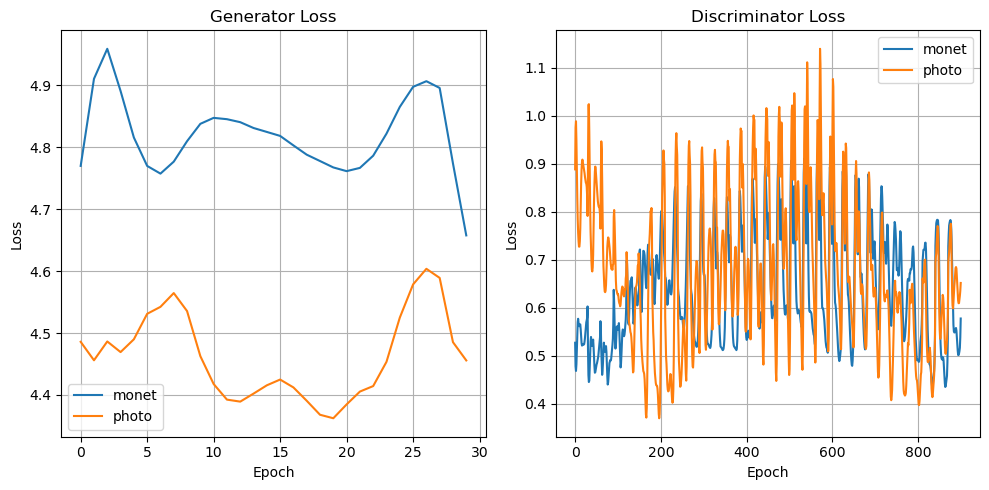

In [8]:
def plot_hist(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    #plt.plot(np.mean(hist.history['monet_gen_loss'][0][0], axis=1))
    #plt.plot(np.mean(hist.history['photo_gen_loss'][0][0], axis=1))    
    plt.plot(hist.history['monet_gen_loss'][0][0].flatten())
    plt.plot(hist.history['photo_gen_loss'][0][0].flatten())   
    plt.legend(["monet","photo"])
    plt.title('Generator Loss')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['monet_disc_loss'][0][0].flatten())
    plt.plot(hist.history['photo_disc_loss'][0][0].flatten())
    plt.title("Discriminator Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["monet","photo"])
    plt.tight_layout()
    plt.show()

plot_hist(history)

Finally, let's use the generated to generate ~7k images and save / submit the notebook to kaggle.

In [ ]:
! mkdir ../images

def generate(dataset):
    dataset_iter = iter(dataset)
    out_dir = '../images/'
    for i in tqdm.tqdm(range(n_photo_samples)):
        # Get the image from the dataset iterator
        img = next(dataset_iter)
        prediction = model.generate(img)
        prediction = tf.squeeze(prediction).numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   
        plt.imsave(os.path.join(out_dir, 'image_{:04d}.jpg'.format(i)), prediction)

generate(photo_ds)

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

The next figure shows few of the images generated.

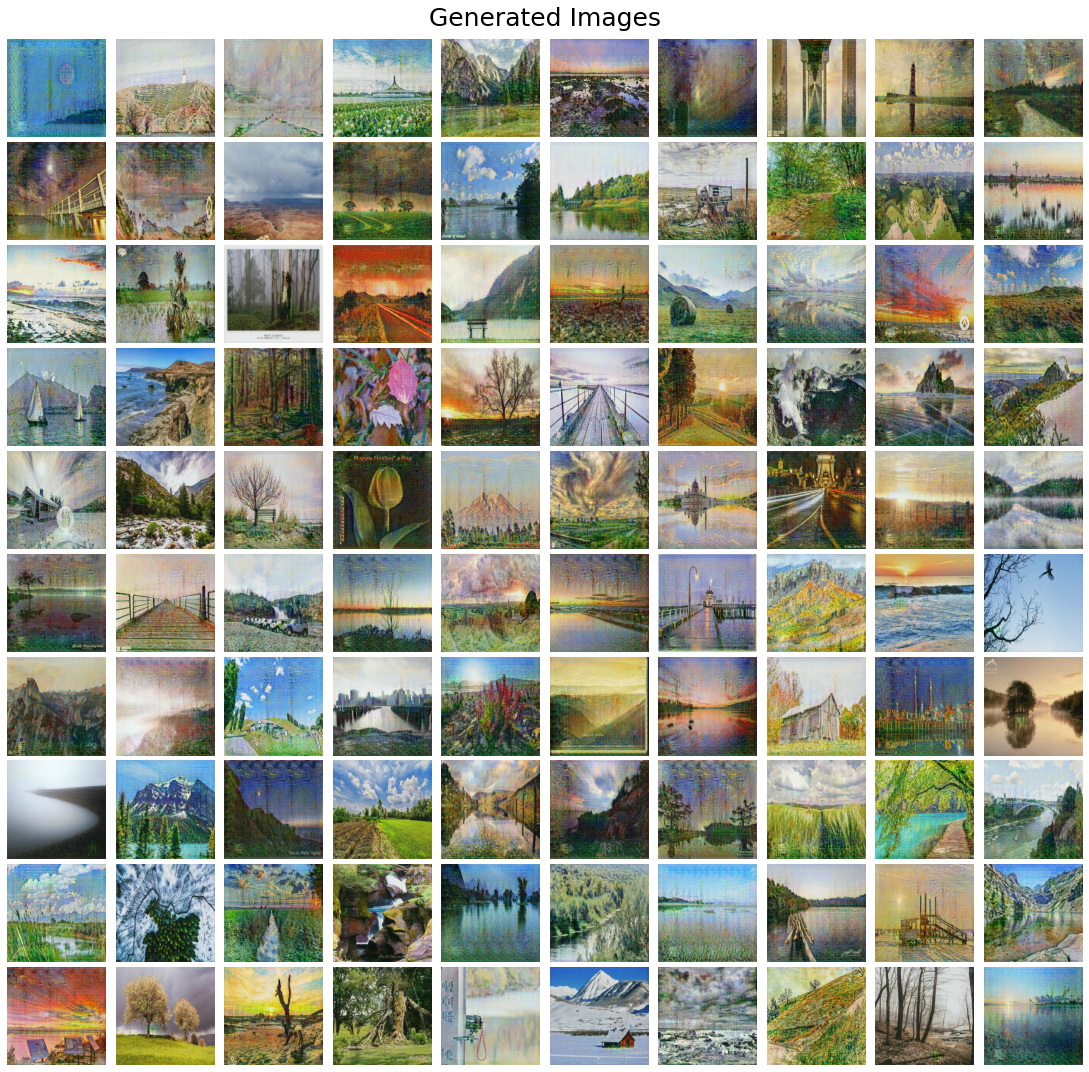

In [9]:
plot_images([plt.imread(f) for f in glob('out/*.jpg')[:200]], 'Generated Images')

![](images/igen.png)

## Git Repository

https://github.com/sandipan/Monet-Style-Transfer-with-GANs-Kaggle-Mini-Project

## Kaggle Notebook

https://www.kaggle.com/code/sandipanumbc/monet-style-transfer-with-cyclegan

## Conclusion

As we can see from the above results, the CycleGAN does a pretty good job in generating the monet-style images from photos. The model was trained for 50 epochs, it seems that losses will decrease further if increased for more epochs (e.g., 100), we can get a better model. 

Kaggle uses an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images. The score obtained on Kaggle is ~54.18 and the leaderboard position is 49, as shown in the following screenshots.

![](submission.png)
![](leaderboard.png)